# Initial Imports

In [74]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## MAKE A CNN

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Reshape
from imblearn.over_sampling import SMOTE
from keras.layers import LSTM

# Load in Data 

In [76]:
malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

# Merge data files into single DataFrame

In [77]:
malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6387 entries, 0 to 6386
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          6387 non-null   int64  
 1   Twitter ID              4664 non-null   float64
 2   Related Online Post ID  1177 non-null   float64
 3   Source ID               6387 non-null   object 
 4   Online Post Text        1723 non-null   object 
 5   Subjectivity            6387 non-null   int64  
 6   Sentiment Polarity      6387 non-null   object 
 7   Emotion                 6387 non-null   object 
 8   Sarcasm                 6387 non-null   int64  
 9   Irony                   6387 non-null   int64  
 10  Negation                6387 non-null   int64  
 11  Off-topic               6387 non-null   int64  
 12  Language                6387 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 648.8+ KB


# Clean up of data columns 

In [78]:
clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [79]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 5072
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  1114 non-null   int64 
 1   Text                1114 non-null   object
 2   Subjectivity        1114 non-null   int64 
 3   Sentiment Polarity  1114 non-null   object
 4   Emotion             1114 non-null   object
 5   Sarcasm             1114 non-null   int64 
 6   Irony               1114 non-null   int64 
 7   Negation            1114 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 78.3+ KB


# Emotion data Exploration

In [80]:
print(clean_data["Emotion"].unique().tolist())
clean_data["Emotion"].value_counts()

['trust', 'disgust', 'anticipation', 'sadness', 'anger', 'fear', 'surprise', 'joy']


Emotion
disgust         253
anger           225
anticipation    199
sadness         138
joy              95
surprise         92
trust            67
fear             45
Name: count, dtype: int64

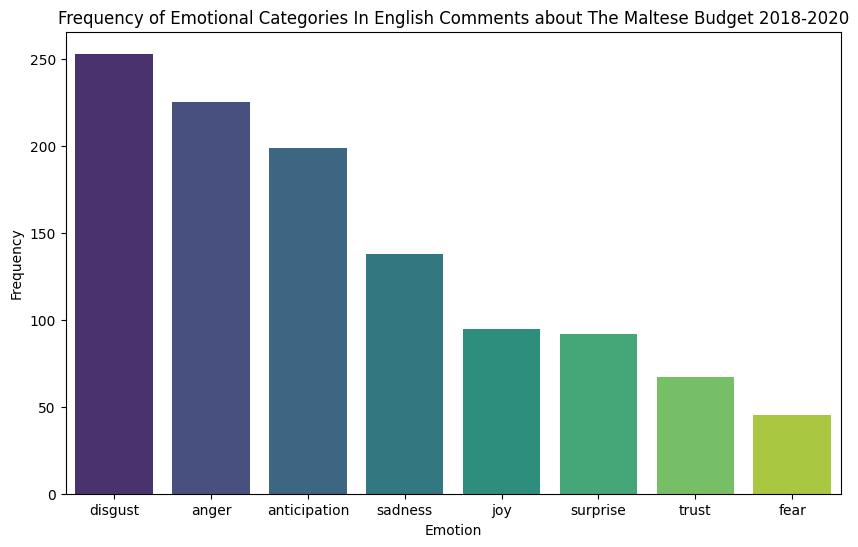

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

value_counts = clean_data['Emotion'].value_counts()

# Plotting the frequency of string values in the 'Category' column
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis', hue=value_counts.index, legend=False)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Frequency of Emotional Categories In English Comments about The Maltese Budget 2018-2020')
plt.show()

In [82]:
max_words = clean_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

The longest record is : 398 words


# Pre Processing of Text

In [104]:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer
from transformers import AutoTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
tokenizer_features = 110000
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
# tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

ax_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

# Encode
# clean_data['encoded'] = clean_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The longest record is : 398 words


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,tokens
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,"[great, budget, even, ci, ##gare, ##tte, touch..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,"[exactly, sc, ##anne, ##d, budget, throughout,..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,"[already, smoking, ces, ##sation, program, peo..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,"[alcohol, fuel, private, vehicle, raising, tax..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,"[practical, say, third, world, country, suppos..."


In [105]:
 # Tokenize and Encode 
def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 180)
 

In [106]:
stripped_data = processed_data.drop(columns=['Subjectivity','Sentiment Polarity', 'Sarcasm','Irony','Negation'])
stripped_data.head()

,ID,Text,Emotion,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,trust,"[great, budget, even, ci, ##gare, ##tte, touch...","[101, 11838, 21455, 12818, 11200, 46511, 11993...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,disgust,"[exactly, sc, ##anne, ##d, budget, throughout,...","[101, 56938, 16427, 31570, 10163, 21455, 15410...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,anticipation,"[already, smoking, ces, ##sation, program, peo...","[101, 18874, 67503, 12139, 22337, 11660, 11227...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,sadness,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 31329, 26150, 13742, 23247, 47651, 22389...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,anger,"[practical, say, third, world, country, suppos...","[101, 37872, 16497, 12047, 10228, 11913, 54838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


In [107]:
overall_max = max(stripped_data['padded'].apply(max))
print("The highest number overall is:", overall_max)

The highest number overall is: 96574


In [108]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.6188888888888889, 1: 0.699748743718593, 2: 0.5503952569169961, 3: 3.0944444444444446, 4: 1.4657894736842105, 5: 1.0090579710144927, 6: 1.513586956521739, 7: 2.078358208955224}


In [109]:

from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

maximum_length = 180  # Maximum length of input sequences

x_data = np.asarray(stripped_data['padded'].to_list())
# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

# LSTM Model Architecture
max_features = tokenizer_features # 30522 or 110000
embedding_dim = int(tokenizer_features / 30) # Should this value to be based on the total unique tokens or the max_features?

inputs = Input(shape=(maximum_length,), dtype='int32')
x = Embedding(input_dim=max_features, output_dim=embedding_dim)(inputs)

# # LSTM 
# x = Conv1D(128, 8, activation='relu')(x)
# x = MaxPooling1D(padding="same")(x)
# x = LSTM(128, return_sequences=True)(x)
# x = Flatten()(x)
# x = Dropout(0.2)(x)
# x = Dense(64, activation='relu')(x)

# # CNN
x = Conv1D(256, 2, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x) #256
x = Dropout(0.2)(x)

# # CNN 2
# x = Conv1D(512, 32, activation='relu')(x)
# x = GlobalMaxPooling1D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
# x = Dense(16, activation='relu')(x)

outputs = Dense(y_data.shape[1], activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
batch_size = 32
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Shape of training data:
(891, 180)
(891, 8)
Shape of test data:
(223, 180)
(223, 8)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 180, 3666)      │   403,260,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 179, 256)       │     1,877,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,154,216 (1.51 GB)

 Trainable params: 405,154,216 (1.51 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/homebrew/lib/python3.11/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 403260000 elements. This may consume a large amount of memory.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.1094 - loss: 2.1008 - val_accuracy: 0.1883 - val_loss: 2.0311
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.4540 - loss: 1.7066 - val_accuracy: 0.1973 - val_loss: 1.9699
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.7336 - loss: 1.0840 - val_accuracy: 0.2915 - val_loss: 1.9007
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.9102 - loss: 0.4547 - val_accuracy: 0.2466 - val_loss: 1.9750
Epoch 5/10
25/28 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.9720 - loss: 0.1588

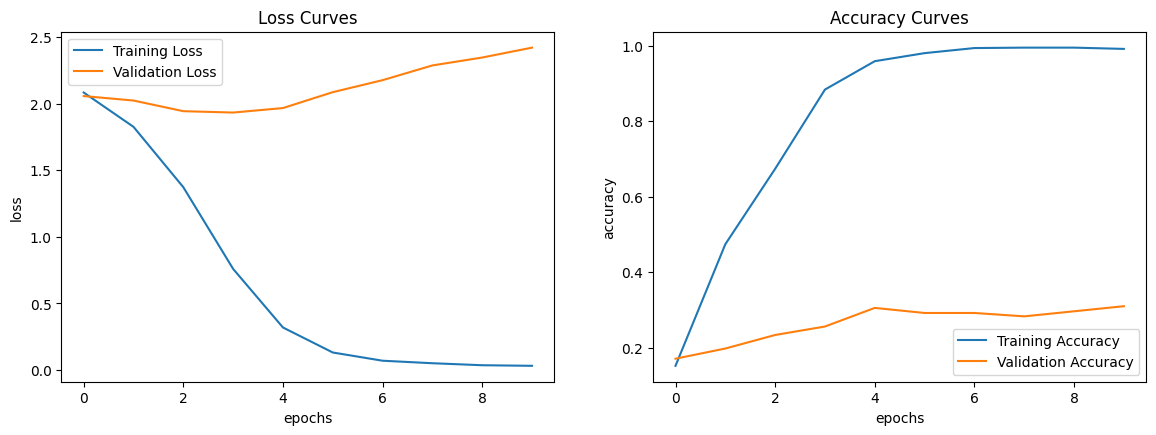

In [103]:
tr_loss = history.history[ 'loss']
val_loss = history.history['val_loss']
tr_acc = history.history[ 'accuracy']
val_acc = history.history[ 'val_accuracy']
epochs = range(len(tr_loss)) # get the epochs as a list to plot along the x-axis

plt.figure(figsize=(14,10))
# Loss curves
ax = plt.subplot(2,2,1)
plt.plot(epochs, tr_loss, label='Training Loss') 
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curves')
plt.legend()
# Accuracy curves
ax = plt.subplot(2,2,2)
plt.plot(epochs, tr_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Curves')
plt.legend()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

     disgust       0.20      0.16      0.17        45
       anger       0.38      0.45      0.41        40
anticipation       0.40      0.57      0.47        51
     sadness       0.29      0.22      0.25         9
         joy       0.35      0.32      0.33        19
    surprise       0.19      0.18      0.19        28
       trust       0.00      0.00      0.00        18
        fear       0.15      0.15      0.15        13

    accuracy                           0.31       223
   macro avg       0.25      0.26      0.25       223
weighted avg       0.27      0.31      0.29       223



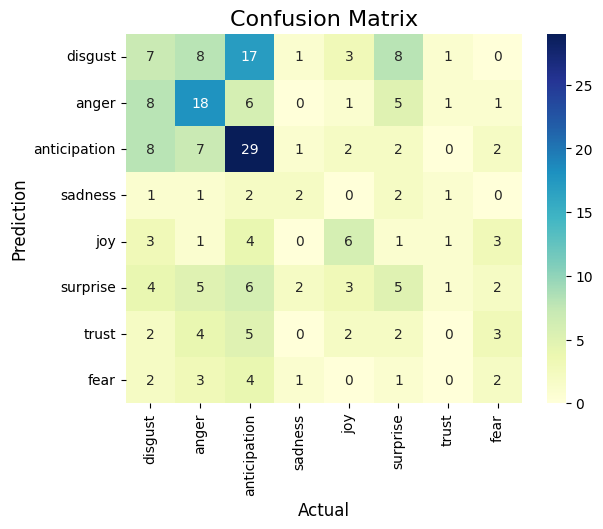

In [91]:
labels = ['disgust', 'anger', 'anticipation', 'sadness','joy', 'surprise', 'trust', 'fear']

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))

cm = confusion_matrix(Y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

In [50]:
from transformers import AutoModelForSequenceClassification

## TODO: use pretrained model instead 
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))

cm = confusion_matrix(Y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: 'BertForSequenceClassification' object has no attribute 'predict'

# Potential ideas below and trials below

# Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

train_df, test_df = train_test_split(stripped_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['Text'])
X_test = vectorizer.transform(test_df['Text'])

# Labels
y_train = train_df['Emotion']
y_test = test_df['Emotion']

# Training Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Predicting on test data
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# CNN with Tokenisation

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

# Tokenization and Padding
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(stripped_data['Text'])
sequences = tokenizer.texts_to_sequences(stripped_data['Text'])
x_data = pad_sequences(sequences, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with One Hot Encoding 

In [ ]:
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with label encoding

# CNN with Oridinal encoding

# CNN with VAE endcoding

# CNN with BagOfWords

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag-of-Words Vectorization
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)

count_vectorizer = CountVectorizer(max_features=max_features)
x_data = count_vectorizer.fit_transform(stripped_data['Text']).toarray()

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Dense(embedding_dim, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Reshape((embedding_dim, 1)))  # Reshape to match Conv1D input shape
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Reshape

# TF-IDF Vectorization
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)

tfidf = TfidfVectorizer(max_features=max_features)
x_data = tfidf.fit_transform(stripped_data['Text']).toarray()

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Dense(embedding_dim, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Reshape((embedding_dim, 1)))  # Reshape to match Conv1D input shape
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with N-Grams

In [ ]:
# Tokenization and Padding using Tokenizer with n-grams
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
n_gram_range = 2  # Unigram and bigram

# Function to add n-grams
def create_ngram_set(input_list, ngram_value=2):
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

def add_ngram(sequences, token_index, ngram_range=2):
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for ngram in create_ngram_set(input_list, ngram_value):
                if ngram in token_index:
                    new_list.append(token_index[ngram])
                else:
                    # Add a new token to the index
                    token_index[ngram] = len(token_index) + 1
                    new_list.append(token_index[ngram])
        new_sequences.append(new_list)
    return new_sequences

# Tokenizer initialization and fitting
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(stripped_data['Text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(stripped_data['Text'])

# Add n-gram features
token_index = tokenizer.word_index.copy()  # Copy the word index
sequences_ngram = add_ngram(sequences, token_index, n_gram_range)

# Pad sequences
x_data = pad_sequences(sequences_ngram, maxlen=max_len)

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=len(token_index) + 1, output_dim=embedding_dim))  # Adjust input_dim
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN Mark II

In [ ]:
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(100, 2, activation='relu'))
# model.add(Dropout(0.2))
model.add(Conv1D(100, 3, activation='relu'))
# model.add(Dropout(0.2))
model.add(Conv1D(100, 4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with SMOTE (for undistributed data)

In [ ]:
from imblearn.over_sampling import SMOTE

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20#30
epochs = 20
model.fit(X_train_resampled, y_train_resampled, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with Class Weights (for undistributed data) 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

adasyn = ADASYN(sampling_strategy='minority')
X_res, y_res = adasyn.fit_resample(X_train, y_train)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_res, y_res, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with NearMiss

In [ ]:
from imblearn.under_sampling import NearMiss

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

nearmiss = NearMiss(version=1)
X_res, y_res = nearmiss.fit_resample(X_train, y_train)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_res, y_res, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with Borderline_SMOTE

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

borderline_smote = BorderlineSMOTE()
X_res, y_res = borderline_smote.fit_resample(X_train, y_train)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_res, y_res, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with SMOTE + Tomek Links (SMOTETomek)

In [ ]:
from imblearn.combine import SMOTETomek

# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

smote_tomek = SMOTETomek()
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

# CNN Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))  # Specify input_dim instead of input_length
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_res, y_res, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with Word2Vec embedding

In [ ]:
from gensim.models import KeyedVectors

# Path to the pre-trained Word2Vec file
word2vec_path = '../data/GoogleNews-vectors-negative300.bin'

# Load Word2Vec model
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)

# Assuming 'stripped_data' contains your text data
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(stripped_data['Text'])

sequences = tokenizer.texts_to_sequences(stripped_data['Text'])
x_data = pad_sequences(sequences, maxlen=max_len)

# Convert categorical labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_dim = 300  # Assuming your Word2Vec model has embeddings of size 300

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_features:
        continue
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    # If word not found in embedding index, leave it as zero-vector or initialize randomly
    
# Optionally, you can normalize the embedding matrix
# embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis=-1, keepdims=True)

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_data.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

batch_size = 20
epochs = 20

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN GloVe embedding


In [ ]:
# Load GloVe embeddings
embedding_dim = 100
# gloVe_loc = "../data/glove.840B.300d.txt"  # Path to GloVe file
gloVe_loc = "../data/glove.6B.100d.txt"
embeddings_index = {}

# Determine embedding dimension automatically
with open(gloVe_loc, 'r', encoding='utf-8') as f:
    first_line = f.readline()
    embedding_dim = len(first_line.split()) - 1  # The number of dimensions is one less than the number of columns

# Reload the GloVe file to build the embeddings_index
with open(gloVe_loc, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            print(f"Skipping line: {line}")
            
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)
encoded_docs = [one_hot(d, max_features) for d in stripped_data['Text']]
x_data = pad_sequences(encoded_docs, maxlen=max_len)
y_data = pd.get_dummies(stripped_data['Emotion']).values  # Convert categorical labels to one-hot encoded vectors

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
print('Shape of training data: ')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data: ')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
word_index = {word: i for i, word in enumerate(embeddings_index.keys(), 1)}  # Build word index
for word, i in word_index.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build CNN Model with GloVe embeddings
model = Sequential()
model.add(Input(shape=(max_len,), dtype='int32'))
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))  # Pre-trained GloVe embeddings
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 32
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with FastText

# CNN with LSTM

In [ ]:
from keras.layers import LSTM
# Tokenization and Padding using one_hot
max_features = 10000  # Max number of words in tokenizer
max_len = 100  # Max length of each sequence (pad/truncate to this length)

tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(stripped_data['Text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(stripped_data['Text'])

# Pad sequences
x_data = pad_sequences(sequences, maxlen=max_len)

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(stripped_data['Emotion']), y=stripped_data['Emotion'])
class_weights = dict(enumerate(class_weights))

# LSTM Model Architecture
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_data.shape[1], activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), class_weight=class_weights)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with Contextualised Embedding

# CNN with BERT

In [ ]:
from transformers import BertTokenizer, TFBertModel
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences in the dataset
def encode_texts(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return np.array(input_ids), np.array(attention_masks)

max_len = 100  # Max length of each sequence
input_ids, attention_masks = encode_texts(stripped_data['Text'].tolist(), tokenizer, max_len)

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train_ids, X_test_ids, y_train, y_test = train_test_split(input_ids, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
X_train_masks, X_test_masks, _, _ = train_test_split(attention_masks, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train_ids.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test_ids.shape)
print(y_test.shape)

# Build the model
input_ids = Input(shape=(max_len,), dtype='int32', name='input_ids')
input_masks = Input(shape=(max_len,), dtype='int32', name='attention_masks')

bert_output = bert_model(input_ids, attention_mask=input_masks)[0]
x = LSTM(128, return_sequences=True)(bert_output)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(y_data.shape[1], activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

model = Model(inputs=[input_ids, input_masks], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 16
epochs = 3
model.fit([X_train_ids, X_train_masks], y_train, batch_size=batch_size, epochs=epochs, validation_data=([X_test_ids, X_test_masks], y_test))

# Evaluate the model
loss, accuracy = model.evaluate([X_test_ids, X_test_masks], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with ELMo

In [ ]:
from allennlp.modules.elmo import Elmo, batch_to_ids
# Load ELMo model
options_file = 'https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway_options.json'
weight_file = 'https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway_weights.hdf5'
elmo = Elmo(options_file, weight_file, 2, dropout=0)

# Tokenize text and convert to character ids
def tokenize_texts(texts):
    sentences = [text.split() for text in texts]
    character_ids = batch_to_ids(sentences)
    return character_ids

# Convert texts to character ids for ELMo
character_ids = tokenize_texts(stripped_data['Text'].tolist())

# Extract ELMo embeddings
def get_elmo_embeddings(character_ids):
    embeddings = elmo(character_ids)['elmo_representations'][0]
    return embeddings.numpy()

elmo_embeddings = get_elmo_embeddings(character_ids)

# Average the ELMo embeddings across tokens
def average_elmo_embeddings(elmo_embeddings):
    return np.mean(elmo_embeddings, axis=1)

x_data = average_elmo_embeddings(elmo_embeddings)

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test.shape)
print(y_test.shape)

# Build the model
input_dim = X_train.shape[1]  # Number of features in the ELMo embeddings

input_layer = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(y_data.shape[1], activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# CNN with RoBERTa

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel

# Load pre-trained RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Tokenize and encode sequences in the dataset
def encode_texts(texts, tokenizer, max_len):
    encodings = tokenizer(
        texts, 
        truncation=True, 
        padding=True, 
        max_length=max_len, 
        return_tensors='tf'
    )
    return encodings['input_ids'], encodings['attention_mask']

max_len = 100  # Max length of each sequence
input_ids, attention_masks = encode_texts(stripped_data['Text'].tolist(), tokenizer, max_len)

# Convert labels to one-hot encoded vectors
y_data = pd.get_dummies(stripped_data['Emotion']).values

# Splitting data into training and testing sets
X_train_ids, X_test_ids, y_train, y_test = train_test_split(input_ids, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)
X_train_masks, X_test_masks, _, _ = train_test_split(attention_masks, y_data, test_size=0.2, stratify=stripped_data['Emotion'], random_state=42)

print('Shape of training data:')
print(X_train_ids.shape)
print(y_train.shape)
print('Shape of test data:')
print(X_test_ids.shape)
print(y_test.shape)

# Build the model
input_ids_layer = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask_layer = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

roberta_output = roberta_model(input_ids_layer, attention_mask=attention_mask_layer)[0]
x = tf.reduce_mean(roberta_output, axis=1)  # Average pooling over the sequence
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
output = Dense(y_data.shape[1], activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training the model
batch_size = 20
epochs = 20
model.fit([X_train_ids, X_train_masks], y_train, batch_size=batch_size, epochs=epochs, validation_data=([X_test_ids, X_test_masks], y_test))

# Evaluate the model
loss, accuracy = model.evaluate([X_test_ids, X_test_masks], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)